# Improve first preprocessing pipeline

Based on the previous notebook that build a first pipeline let's try to create a better one.

Some problems to fix:
- [x] When croping after rotating an image, the top and bottom are cut
- [ ] Some texts diseapear when thresholding
- [ ] Identify text box before

## Import packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dyslexia import preprocessing
from dyslexia.io import load_image
from dyslexia.ocr import extract_text_from_image
from dyslexia.plots import plot_image, plot_n_images

import time

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
%env TESSDATA_PREFIX /usr/share/tesseract-ocr/4.00/tessdata/

env: TESSDATA_PREFIX=/usr/share/tesseract-ocr/4.00/tessdata/


## Get files


In [4]:
from utils import load_all_files_path

subdir_paths, all_files = load_all_files_path()

### Define some examples to work on

In [5]:
examples_path = [
    '../Exemples/Ex_Maths/IMG_20210329_123813.jpg',
    '../Exemples/Ex_Maths/IMG_20210329_122157.jpg',
    '../Exemples/Present_indicatif/IMG_20210329_122337.jpg',
    '../Exemples/Ex_COD/IMG_20210329_122755.jpg',
    '../Exemples/SVT/IMG_20210329_123132.jpg',
    '../Exemples/SVT/IMG_20210329_123025.jpg',
    '../Exemples/Dictee/IMG_20210329_122825.jpg',
    '../Exemples/Histoire_Geo/IMG_20210329_122932.jpg',
    '../Exemples/Histoire_Geo/IMG_20210329_122940.jpg',
]

## Create preprocess function

This is a working section so it will changes while working on this notebook

In [6]:
def preprocess_image(image):    
    image_no_shadow = preprocessing.remove_shadow(image)
    
    image_gray = preprocessing.image_to_gray(image_no_shadow, threshold=True)

    angle = preprocessing.find_best_rotation_angle(image_gray)

    image_fixed = preprocessing.rotate_img(image_gray, angle=angle)
    
    return image_fixed

In [7]:
def pipeline(fpath):
    image_orig = load_image(fpath)
    
    image_prep = preprocess_image(image_orig)
    
    return (image_orig, image_prep)

def run_preprocess_on_file(fpath):
    t0 = time.time()
    images = pipeline(fpath)
    t_end = time.time() - t0
    
    print('Run in %.2fs'%t_end)

    plot_n_images(images, figsize=(15,7))

def run_preprocess_on_files(files):
    
    for fpath in files:
        print(fpath)
        run_preprocess_on_file(fpath)

In [8]:
plot_image(image_orig)

NameError: name 'image_orig' is not defined

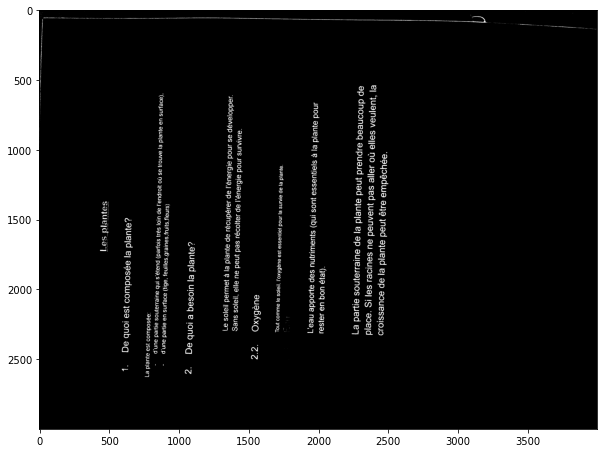

In [39]:
p = '../Exemples/SVT/IMG_20210329_123025.jpg'
# P = '../Exemples/Ex_Maths/IMG_20210329_123813.jpg'
image_orig = load_image(p)
image_no_shadow = preprocessing.remove_shadow(image_orig)

image_gray = preprocessing.image_to_gray(image_no_shadow, threshold=True)
plot_image(image_gray)

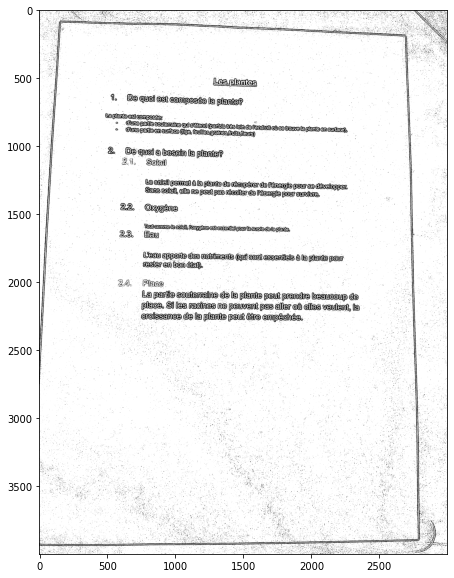

In [40]:
p = all_files[22]

def preprocess_image(image):    
    image_no_shadow = preprocessing.remove_shadow(image)
    
    image_gray = preprocessing.image_to_gray(image_no_shadow, threshold=True)
    
    return image_gray

    angle = preprocessing.find_best_rotation_angle(image_gray)

    image_fixed = preprocessing.rotate_img(image_gray, angle=angle)
    
    return image_fixed

image = load_image(p)

image_prep = preprocess_image(image)

# image_prep = cv2.bitwise_not(image_prep)

plot_image(image_prep)

In [41]:
res = extract_text_from_image(image_prep)

In [42]:
print(res)

  
   
     
   
  
  
   
   
   

_._al_aﬂ_e_

  

 

cemposee &=3

omposèe; s0T - L
pard caitereire 8@?äﬁﬂ(ﬁ)äl‘x‘lälëﬁïäa : ; =
…ÜËÉË fellles ra n.f …ŒÜËÎËËRŒŒŒ!Œ(ËEŒJŒŒ…

rults,ﬂeu)

   

   

â @ü@
…îl ÎÎ c

Ï récupere évelopper

@aæ@ï@æ…

   

 

 

ts en ys tertentapartonti en

 

L 8pport€plante

; '@ä@î@ûüëﬁﬁ):

S seuterame beaucaup “
L,®î[kä—3…lﬁïä_êﬂkä{î‘ﬁ@l@ê |

   

 
 

 

     
 



../Exemples/Ex_Maths/IMG_20210329_123813.jpg


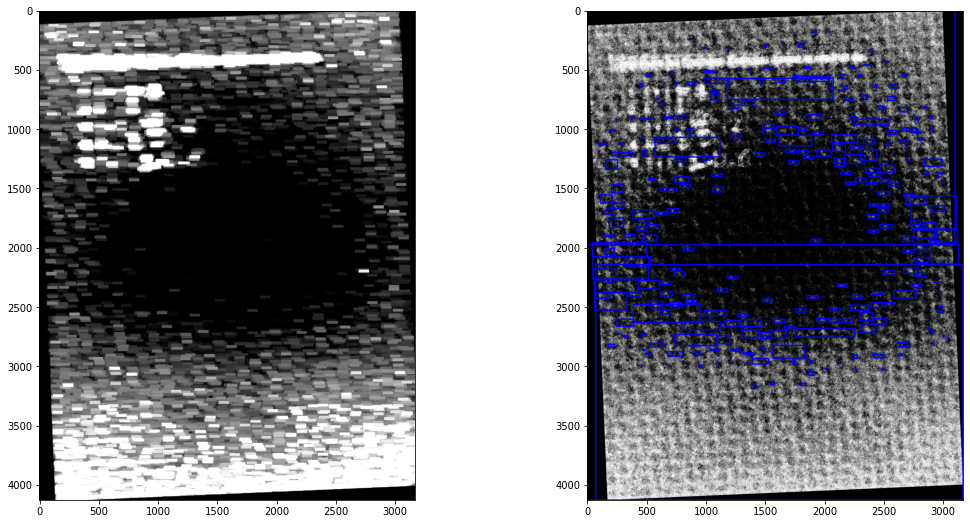

In [53]:
p = '../Exemples/Dictee/IMG_20210329_122825.jpg'

def union(a,b):
    x = min(a[0], b[0])
    y = min(a[1], b[1])
    w = max(a[0]+a[2], b[0]+b[2]) - x
    h = max(a[1]+a[3], b[1]+b[3]) - y
    return (x, y, w, h)

def has_an_intersection(a,b):
    x = max(a[0], b[0])
    y = max(a[1], b[1])
    w = min(a[0]+a[2], b[0]+b[2]) - x
    h = min(a[1]+a[3], b[1]+b[3]) - y
    
    return (w > 0) and (h > 0)

def merge_contours(contours):
    cnt_has_intersect = True
    _while_cond = False
    
    while cnt_has_intersect:
        drop_idx = list()
        new_contours = list()
        
        for i, cnt1 in enumerate(contours):
            has_merged = False
            
            if i == len(contours) - 1:
                continue
                
            for j, cnt2 in enumerate(contours[i+1:]):
                if has_an_intersection(cnt1, cnt2):
                    _while_cond = has_merged = True
                    new_contours.append(union(cnt1, cnt2))
                    drop_idx += [i, i+j]
        
        cnt_has_intersect = _while_cond
        _while_cond = False
    
    print(drop_idx)


for fpath in examples_path:
    print(fpath)
    # img_orig = load_image(p)

    image_orig, image_prep = pipeline(fpath)
#     image_prep = preprocessing.rotate_img(image_prep, 180)
#     image_orig = preprocessing.rotate_img(image_orig, -90)

    # ====================================================================== # 
    #--- choosing the right kernel
    #--- kernel size of 3 rows (to join dots above letters 'i' and 'j')
    #--- and 10 columns to join neighboring letters in words and neighboring words
    # rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    # dilation = cv2.dilate(image_prep, rect_kernel, iterations = 1)

    kernel = np.ones((5, 5), np.uint8)
    dilation = cv2.morphologyEx(image_prep, cv2.MORPH_OPEN, kernel)
    kernel = np.ones((1, 9), np.uint8)
    dilation = cv2.morphologyEx(dilation, cv2.MORPH_CLOSE, kernel)
    # kernel = np.ones((9, 1), np.uint8)
    # dilation = cv2.morphologyEx(dilation, cv2.MORPH_CLOSE, kernel)

    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 3))
    dilation = cv2.dilate(dilation, rect_kernel, iterations = 9)

#     contours, hierarchy = cv2.findContours(
#         dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours, hierarchy = cv2.findContours(
        dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    image_prep = cv2.cvtColor(image_prep, cv2.COLOR_GRAY2BGR) 
    for cnt in contours:

        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(image_prep, (x, y), (x + w, y + h), (0, 0, 255), 10)

    # ======================================================================# 

    plot_n_images((dilation, image_prep))
    break

../Exemples/Ex_Maths/IMG_20210329_123813.jpg
Run in 2.85s


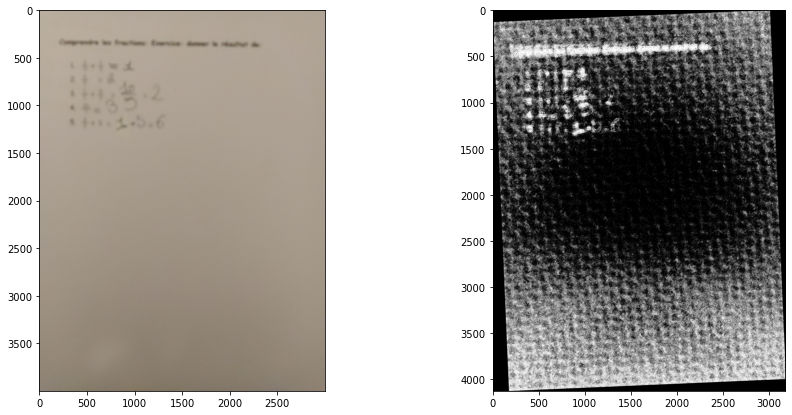

../Exemples/Ex_Maths/IMG_20210329_122157.jpg
Run in 1.48s


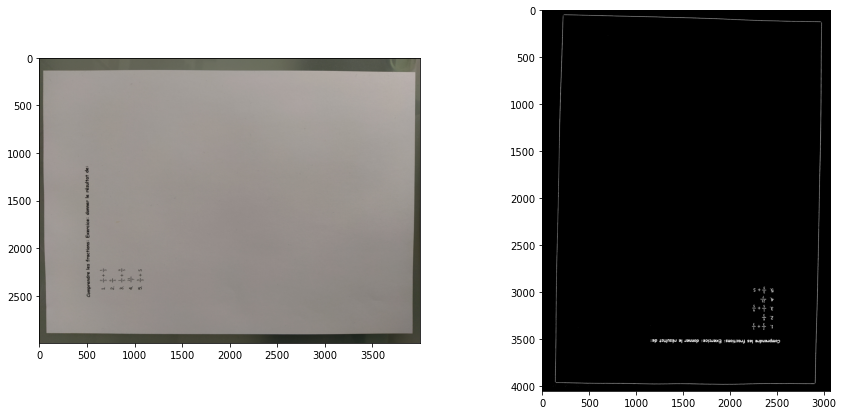

../Exemples/Present_indicatif/IMG_20210329_122337.jpg
Run in 1.97s


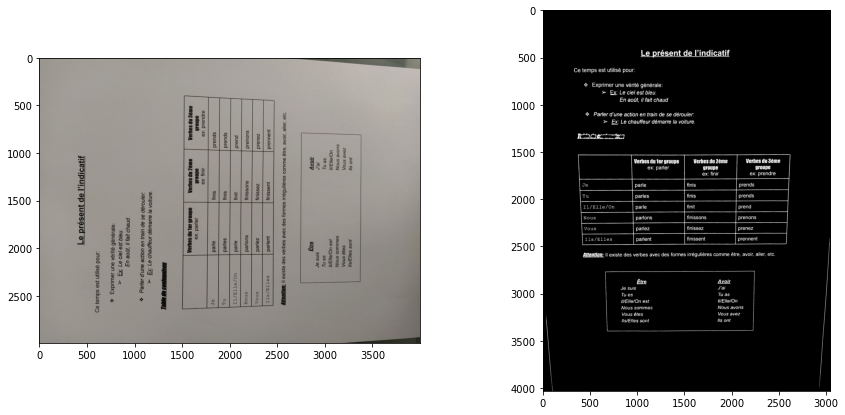

../Exemples/Ex_COD/IMG_20210329_122755.jpg
Run in 2.61s


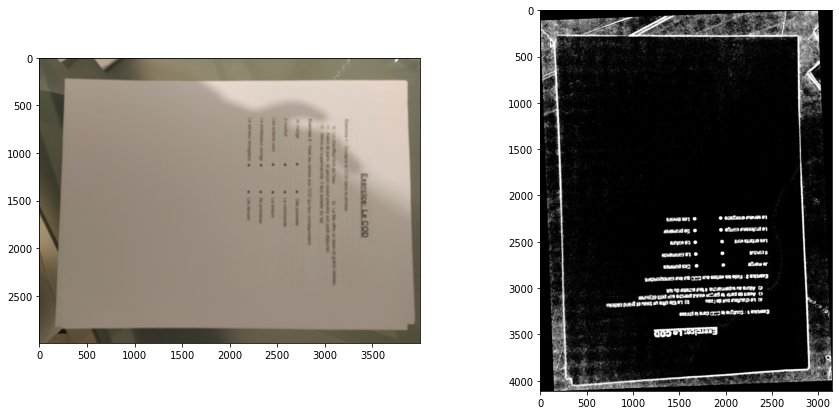

../Exemples/SVT/IMG_20210329_123132.jpg
Run in 2.99s


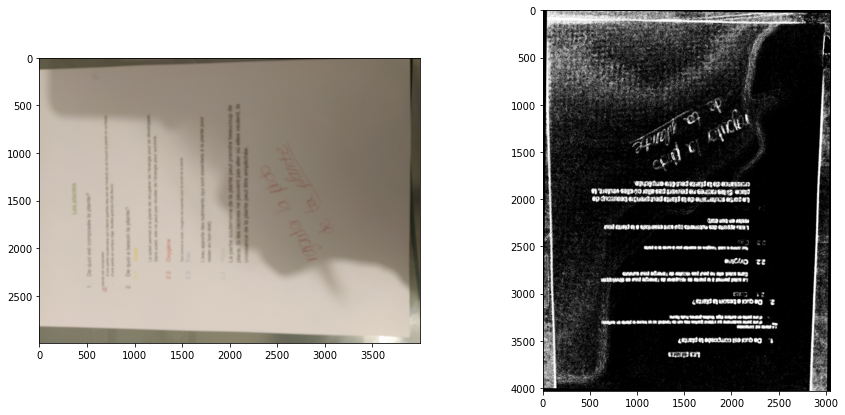

../Exemples/SVT/IMG_20210329_123025.jpg
Run in 1.70s


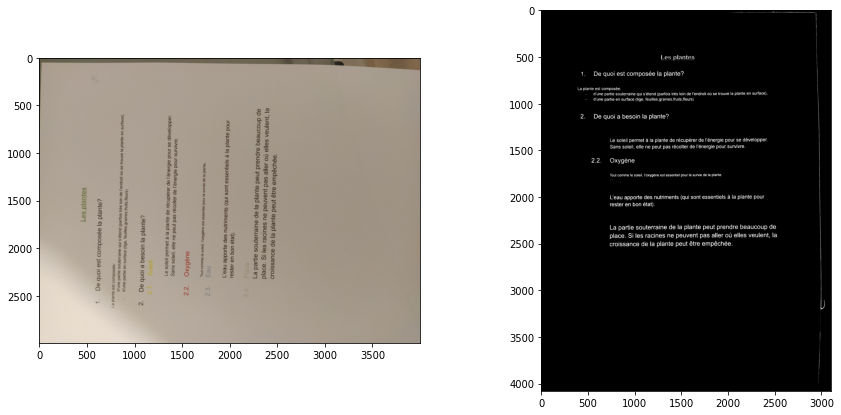

../Exemples/Dictee/IMG_20210329_122825.jpg
Run in 2.54s


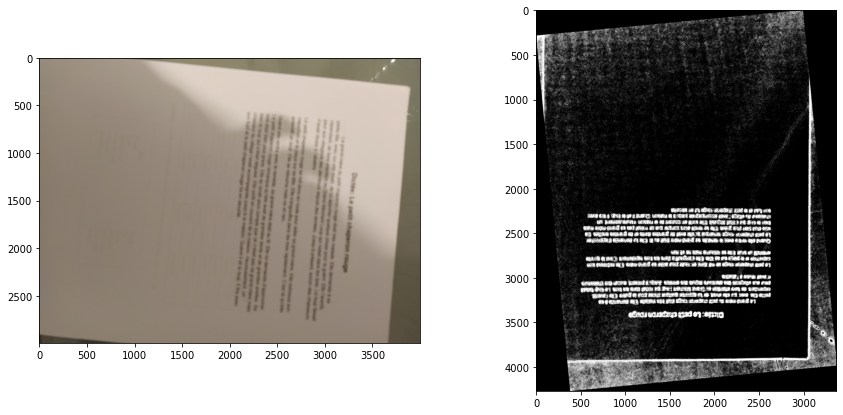

../Exemples/Histoire_Geo/IMG_20210329_122932.jpg
Run in 1.61s


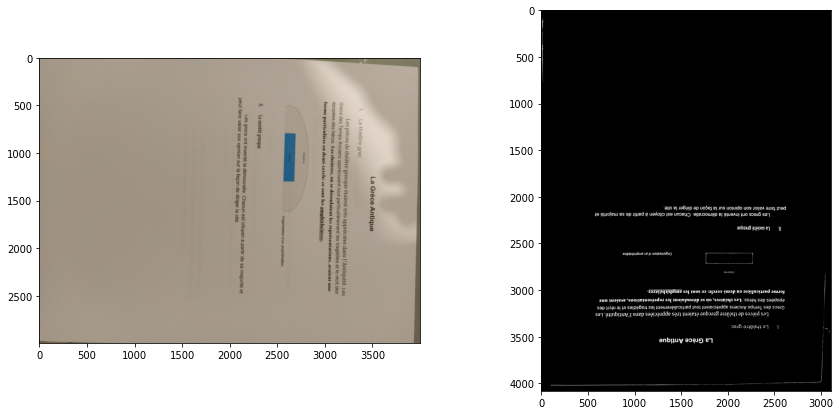

../Exemples/Histoire_Geo/IMG_20210329_122940.jpg
Run in 2.81s


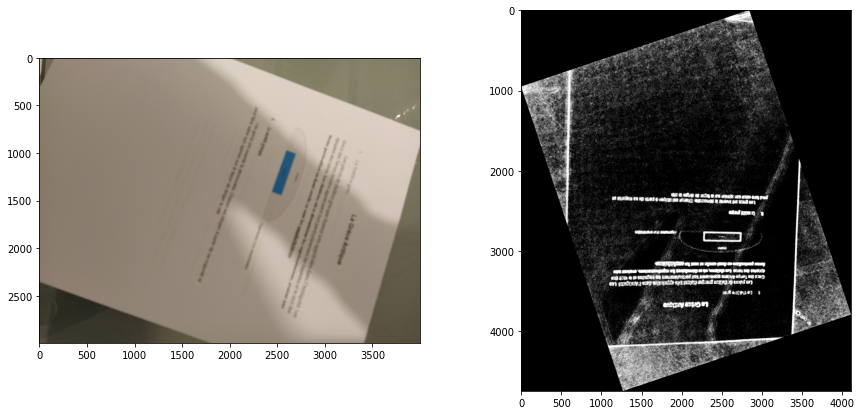

In [27]:
run_preprocess_on_files(examples_path)